# IBM Data Science Capstone Project Problem Definition and Data

## Problem definition

## A theoretical business problem was chosen for this project. The question to be answered is the following

     A successful owner of multiple mid to high-end restaurants decided to open a new restaurant in São Paulo, Brazil. Having visited the city many times in recent yearsm he couldn't disregard the big boom in gastronomy. He is keen on opening a new unit, which will focus on the Italian kitchen.
     Taking in account the price level at which the restaurants will operate, the intent is to find an optimal location in an aream where gastronomy is booming and which is easily accessible for tourists and for weaslthier local citizens as well.

## Assumptions, business logic

    The assumption behind the analysis is that we can use unsupervised machine learning to create cluesters of districts that will provide us with a lista of areas for consideration for the restaurant. The intent is that the restaurant to be situated close to one of the gastronomical centres.
    
## Data

    To perform this analysis, we will need the following data:
    
    1. Lis of the districts of São Paulo
    2. Geo-coordinates of the districts in São Paulo
    3. Top venues of districts.
    
    Lis of district will be obtained from wikipedia:                     

        https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_São_Paulo_por_população


    Geo-coordinates of districts will be obtained with the help of the geocoder tool in the notebook.
    Top venues data will be obtained from Foursquare through an API.

## Use of Data and Methodology

    After tidyinf up and exploring the data, we will apply the K-means machine learning technique for creating cluster of districts. We will use the silhouette score for choosing the optimal number of clusters.

# 1. Collecting Data

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


In [2]:
wiki = ' https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_São_Paulo_por_população'
wiki_page = requests.get(wiki)

In [3]:
soup = BeautifulSoup(wiki_page.content, 'html.parser')

In [4]:
table_contents=[]
table=soup.find('table', attrs={'class':'wikitable sortable'}).tbody
rows=table.find_all('tr')
columns_names ={v.text.replace('\n','') for v in rows[0].find_all('th')}

for i in range(1, len(rows)):
    tds=rows[i].find_all('td')
    cells ={}
    
    if len(tds)==3:
        values = [td.text.replace('\n',"") for td in tds]
        cells['Posição']=values[0]
        cells['Distrito']=values[1]
        cells['População']=values[2]
        table_contents.append(cells)

df=pd.DataFrame(table_contents)
df=df.drop(["Posição","População"],axis=1)

In [5]:
result=pd.DataFrame()
district = df['Distrito']
location = None
latitude = None
longitude = None

In [6]:
df.shape

(96, 1)

In [7]:
for data in range(0, len(district)):
    dt = district[data]
    
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(' {},São Paulo, SP'.format(dt),viewbox=((-23.15,-47.17),(-23.59,-46.15))) #view box was used to limit the area of search
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)

    result = result.append({ 'Distrito':dt,'Latitude': location.latitude,'Longitude': location.longitude}, ignore_index=True)

-23.78590725 -46.66519713060974
-23.7125278 -46.7687195
-23.6043265 -46.5098851
-23.6719026 -46.779435420915036
-23.683573250000002 -46.737762089371984
-23.6730116 -46.6552806
-23.4482715 -46.69026927092207
-23.6012824 -46.6025552
-23.5017648 -46.3996091
-23.6520656 -46.650037329076994
-23.5824973 -46.4092065
-23.632557650000003 -46.759666126372395
-23.5360799 -46.4555099
-23.4482881 -46.6029761
-23.71865045 -46.7010388456856
-23.446592000000003 -46.73617751601424
-23.53624775 -46.41002184740884
-23.485533 -46.7219385
-23.5982995 -46.4817046
-23.510151 -46.41789278409091
-22.741347 -46.894846
-23.627159 -46.45324064213981
-23.449511450000003 -46.66366119497354
-23.500294 -46.458717352058315
-23.594946 -46.545899798292474
-23.4874636 -46.6951317
-23.5058996 -46.5314253
-23.48228355 -46.423410226982504
-23.8326395 -46.70985686242149
-23.615177950000003 -46.643393343146286
-23.5837 -46.632740824206934
-23.487707 -46.5844955
-23.523683 -46.5437815
-23.6182115 -46.418977389793156
-23.625687

In [8]:
results=result

In [9]:
#Some outliers were observed. The best solution for these cases was to drop the rows
results=results[results.Distrito != 'Pedreira']
results=results[results.Distrito != 'Marsilac']
results=results[results.Distrito != 'Parelheiros']
results=results[results.Distrito != 'Grajaú']

In [10]:
map_saopaulo = folium.Map(location=[-23.550443, -46.633446], zoom_start=11)

# add markers to map
for lat, lng, district in zip(results['Latitude'], results['Longitude'], results['Distrito']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_saopaulo)  
    
map_saopaulo

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    CLIENT_ID = '0OLGHJWIL4I3JPD1NI3X13XOZLY2VI52SVWTEQNSG0WHTLZF' # your Foursquare ID
    CLIENT_SECRET = 'CXMXHLTPDR40SKZOTHHPHGKRCU00YPO3JTEEH12KM0JRA5ES' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100 # A default Foursquare API limit value

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
saopaulo_venues = getNearbyVenues(names=results.Distrito,
                                   latitudes=results.Latitude,
                                   longitudes=results.Longitude
                                  )

Jardim Ângela
Sapopemba
Capão Redondo
Jardim São Luís
Cidade Ademar
Brasilândia
Sacomã
Itaim Paulista
Jabaquara
Cidade Tiradentes
Campo Limpo
Itaquera
Tremembé
Cidade Dutra
Jaraguá
Lajeado
Pirituba
São Mateus
Vila Curuçá
São Rafael
Cachoeirinha
Vila Jacuí
São Lucas
Freguesia do Ó
Cangaíba
Jardim Helena
Saúde
Vila Mariana
Vila Medeiros
Penha
Iguatemi
Vila Andrade
Cidade Líder
José Bonifácio
Santana
Rio Pequeno
Ermelino Matarazzo
Vila Maria
Perdizes
Cursino
Vila Sônia
Mandaqui
Ipiranga
Artur Alvim
Vila Matilde
Vila Prudente
Guaianases
Campo Grande
Raposo Tavares
Tucuruvi
Vila Formosa
Jaçanã
Ponte Rasa
Itaim Bibi
São Miguel Paulista
Tatuapé
Aricanduva
Jardim Paulista
Casa Verde
Água Rasa
São Domingos
Santa Cecília
Moema
Carrão
Limão
Perus
Santo Amaro
Bela Vista
Liberdade
Parque do Carmo
Anhanguera
Lapa
Pinheiros
Mooca
Campo Belo
Consolação
Vila Guilherme
Butantã
República
Jaguaré
Morumbi
Belém
Alto de Pinheiros
Vila Leopoldina
Socorro
Cambuci
Bom Retiro
Brás
Jaguara
Sé
Pari
Barra Funda


In [25]:
saopaulo_venues.to_csv('saopaulo_venues.csv')

In [14]:
print('There are {} uniques categories.'.format(len(saopaulo_venues['Venue Category'].unique())))

There are 359 uniques categories.


# 2. Analyzing the Districts

In [15]:
teste_venues=saopaulo_venues[saopaulo_venues.duplicated('Venue Category', keep=False)]

Removing rows where values appear once

In [16]:
print('There are {} uniques categories.'.format(len(teste_venues['Venue Category'].unique())))

There are 286 uniques categories.


Considering that São Paulo is one of the biggest city in the world, it may be wiser to reduce the area to be analyze, so firts wi will cluster the areas and select the proper ones

In [17]:
try:
    del results_district
except:
    pass
    
try:
    del results_grouped_clustering
    del kmeans.labels_
except:
    pass

# set number of clusters
kclusters = 6
kmeans=[]
result_grouped_clustering = results.drop('Distrito', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(result_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
result_district = results
result_district.insert(0, 'Cluster Labels', kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
#saopaulo_merged = result_merged.join(neighborhoods_venues_sorted.set_index('District'), on='Distrito').dropna()
result_district.head() # check the last columns!

,Cluster Labels,Distrito,Latitude,Longitude
1,5,Jardim Ângela,-23.712528,-46.768720
2,4,Sapopemba,-23.604326,-46.509885
3,5,Capão Redondo,-23.671903,-46.779435
4,5,Jardim São Luís,-23.683573,-46.737762
5,5,Cidade Ademar,-23.673012,-46.655281


In [18]:
map_clusters = folium.Map(location=[-23.550443, -46.633446], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result_district['Latitude'], result_district['Longitude'], result_district['Distrito'], result_district['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's select the clusters 0, 1 and 3.

In [20]:
result_district=result_district[result_district['Cluster Labels'].isin([0,1,3])]

In [21]:
map_clusters = folium.Map(location=[-23.550443, -46.633446], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result_district['Latitude'], result_district['Longitude'], result_district['Distrito'], result_district['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 3. Preparing the data

## One hot encoding

In [22]:
# one hot encoding
saopaulo_onehot = pd.get_dummies(teste_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
saopaulo_onehot['District'] = teste_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [saopaulo_onehot.columns[-1]] + list(saopaulo_onehot.columns[:-1])
saopaulo_onehot = saopaulo_onehot[fixed_columns]

saopaulo_onehot.head()

,District,Acai House,Accessories Store,Airport,Airport Service,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Gym,College Quad,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store,Empada House,Empanada Restaurant,Escape Room,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Northeastern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Southeastern Brazilian Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Street Food Gathering,Strip Club,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapiocaria,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toll Plaza,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Travel Agency,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studi

In [23]:
saopaulo_grouped = saopaulo_onehot.groupby('District').mean().reset_index()
saopaulo_grouped=saopaulo_grouped[saopaulo_grouped['District'].isin(result_district['Distrito'].unique())]
saopaulo_grouped.head()

,District,Acai House,Accessories Store,Airport,Airport Service,American Restaurant,Amphitheater,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baiano Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Gym,College Quad,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store,Empada House,Empanada Restaurant,Escape Room,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Latin American Restaurant,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mineiro Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Nightclub,Northeastern Brazilian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paella Restaurant,Paintball Field,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Southeastern Brazilian Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Street Food Gathering,Strip Club,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapiocaria,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toll Plaza,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Travel Agency,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studi

In [24]:
num_top_venues = 5

for hood in saopaulo_grouped['District']:
    print("----"+hood+"----")
    temp = saopaulo_grouped[saopaulo_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alto de Pinheiros----
                  venue  freq
0            Restaurant  0.05
1    Athletics & Sports  0.04
2                 Plaza  0.04
3  Brazilian Restaurant  0.03
4        Clothing Store  0.03


----Anhanguera----
               venue  freq
0             Bakery  0.11
1      Grocery Store  0.11
2  Convenience Store  0.11
3               Park  0.11
4              Plaza  0.06


----Barra Funda----
                venue  freq
0         Pizza Place  0.06
1               Motel  0.05
2  Italian Restaurant  0.05
3           Pet Store  0.04
4        Dessert Shop  0.04


----Bela Vista----
                venue  freq
0      Ice Cream Shop  0.07
1             Theater  0.05
2  Italian Restaurant  0.04
3         Coffee Shop  0.04
4                Café  0.04


----Belém----
         venue  freq
0  Pizza Place  0.07
1          Bar  0.06
2   Restaurant  0.04
3    Pet Store  0.03
4         Café  0.03


----Bom Retiro----
                       venue  freq
0  Middle Eastern Restaurant  0.06

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
try: 
    del neighborhoods_venues_sorted
except:
    pass  
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = saopaulo_grouped['District']

for ind in np.arange(saopaulo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(saopaulo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alto de Pinheiros,Restaurant,Plaza,Athletics & Sports,Gym / Fitness Center,Dog Run,Clothing Store,Cosmetics Shop,Brazilian Restaurant,Track,Health Food Store
1,Anhanguera,Bakery,Grocery Store,Convenience Store,Park,Food & Drink Shop,Gym / Fitness Center,Snack Place,Campground,Supermarket,Ice Cream Shop
4,Barra Funda,Pizza Place,Italian Restaurant,Motel,Pet Store,Dessert Shop,Restaurant,Hotel,Theater,Farmers Market,Café
5,Bela Vista,Ice Cream Shop,Theater,Italian Restaurant,Coffee Shop,Café,Hotel,Movie Theater,Cultural Center,Bakery,Bookstore
6,Belém,Pizza Place,Bar,Restaurant,Snack Place,Café,Chocolate Shop,Churrascaria,Ice Cream Shop,Pet Store,Bakery


# 4. Model development

## Using Machine Learning for Clustering Neighborhoods

For clustering, K-means method will be applied. To be able to select the optimal number of clusters, the silhouette score will be used.

First, let's find out the optimal number of clusters. For that, we will create a graph of the silhouette scores.

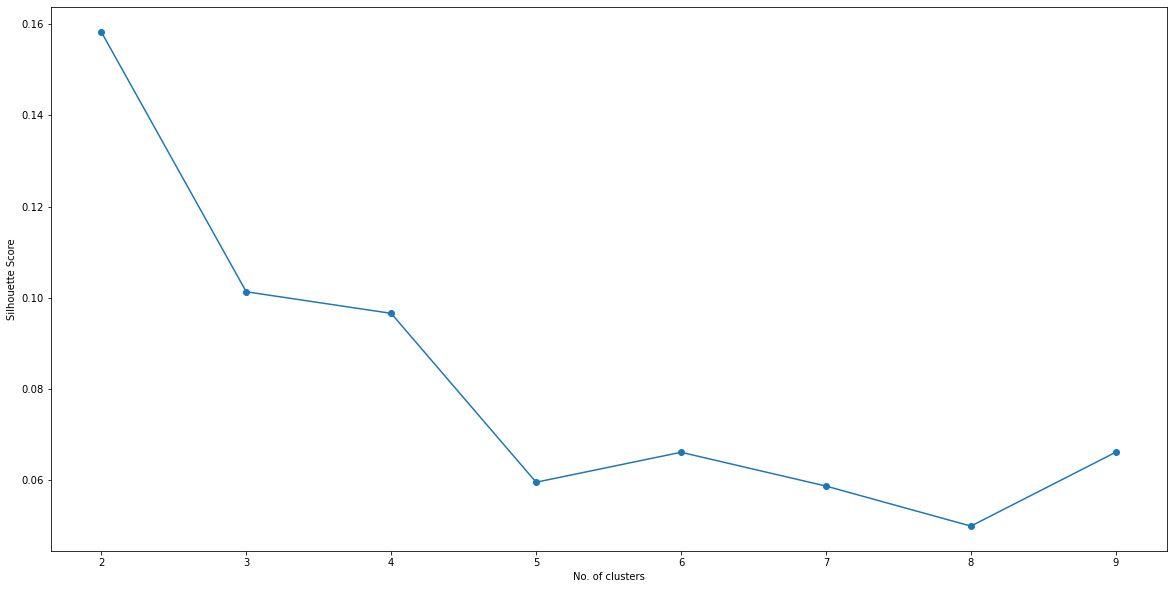

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

max_range = 10

saopaulo_grouped_clustering = saopaulo_grouped.drop('District', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = saopaulo_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

plot(max_range, scores, "No. of clusters", "Silhouette Score")

## Clustering:

In [27]:
# set number of clusters
kclusters = 3
kmeans=[]
saopaulo_grouped_clustering = saopaulo_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(saopaulo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

saopaulo_merged = result_district.drop(['Cluster Labels'], axis=1)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
saopaulo_merged = saopaulo_merged.join(neighborhoods_venues_sorted.set_index('District'), on='Distrito').dropna()
saopaulo_merged.head() # check the last columns!

,Distrito,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Brasilândia,-23.448272,-46.690269,2,Bakery,Gym / Fitness Center,Grocery Store,Snack Place,Big Box Store,Gym,Market,Pharmacy,Pizza Place,Plaza
7,Sacomã,-23.601282,-46.602555,1,Pizza Place,Snack Place,Gym,Bakery,Bar,Burger Joint,Farmers Market,Dessert Shop,Middle Eastern Restaurant,Candy Store
9,Jabaquara,-23.652066,-46.650037,2,Gym / Fitness Center,Bakery,Brazilian Restaurant,Pizza Place,Dessert Shop,Park,Farmers Market,Pharmacy,Japanese Restaurant,Soccer Field
13,Tremembé,-23.448288,-46.602976,2,Bakery,Gym,Supermarket,Ice Cream Shop,Gym / Fitness Center,Pharmacy,Fast Food Restaurant,Pizza Place,Plaza,Grocery Store
15,Jaraguá,-23.446592,-46.736178,2,Bakery,Gym / Fitness Center,Brazilian Restaurant,Pizza Place,Fast Food Restaurant,Miscellaneous Shop,Grocery Store,Gym,Clothing Store,Market


In [28]:
# create map
saopaulo_merged.dropna()

map_clusters = folium.Map(location=[-23.550443, -46.633446], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(saopaulo_merged['Latitude'], saopaulo_merged['Longitude'], saopaulo_merged['Distrito'], saopaulo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Clusters:

### Cluster 1

In [89]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 0, saopaulo_merged.columns[[0] + list(range(4, saopaulo_merged.shape[1]))]]

,Distrito,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,Itaim Bibi,Italian Restaurant,Restaurant,Hotel,Ice Cream Shop,Argentinian Restaurant,Cycle Studio,Café,French Restaurant,Japanese Restaurant,Art Museum
60,Jardim Paulista,Ice Cream Shop,Italian Restaurant,Hotel,Brazilian Restaurant,Art Museum,Restaurant,Cosmetics Shop,Bookstore,Pizza Place,Bakery
64,Santa Cecília,Pizza Place,Italian Restaurant,Theater,Restaurant,Middle Eastern Restaurant,Café,Bakery,Women's Store,Brazilian Restaurant,Fruit & Vegetable Store
70,Bela Vista,Ice Cream Shop,Theater,Italian Restaurant,Coffee Shop,Café,Hotel,Movie Theater,Cultural Center,Bakery,Bookstore
78,Consolação,Bakery,Ice Cream Shop,Italian Restaurant,Hotel,Café,Theater,Pizza Place,Coffee Shop,Brazilian Restaurant,Bookstore
81,República,Theater,Italian Restaurant,Bakery,Sandwich Place,Cultural Center,Grocery Store,Middle Eastern Restaurant,Café,Brazilian Restaurant,Coffee Shop
89,Bom Retiro,Middle Eastern Restaurant,Korean Restaurant,Café,Women's Store,Dessert Shop,Restaurant,Brazilian Restaurant,Bar,Art Museum,Italian Restaurant
90,Brás,Middle Eastern Restaurant,Food & Drink Shop,Pizza Place,Restaurant,Italian Restaurant,Brazilian Restaurant,Bar,Market,Sandwich Place,Arts & Crafts Store
92,Sé,Grocery Store,Bakery,Market,Theater,Food & Drink Shop,Italian Restaurant,Cultural Center,Sandwich Place,Brazilian Restaurant,Middle Eastern Restaurant
93,Pari,Middle Eastern Restaurant,Clothing Store,Churrascaria,Food & Drink Shop,Pet Store,Restaurant,Italian Restaurant,Sandwich Place,Shopping Mall,Market


### Cluster 2

In [90]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 1, saopaulo_merged.columns[[0] + list(range(4, saopaulo_merged.shape[1]))]]

,Distrito,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Sacomã,Pizza Place,Snack Place,Gym,Bakery,Bar,Burger Joint,Farmers Market,Dessert Shop,Middle Eastern Restaurant,Candy Store
29,Saúde,Bakery,Dessert Shop,Pizza Place,Japanese Restaurant,Burger Joint,Pharmacy,Fruit & Vegetable Store,Coffee Shop,Restaurant,Brazilian Restaurant
30,Vila Mariana,Burger Joint,Hostel,Gym / Fitness Center,Bakery,Pizza Place,Food Truck,Pet Store,Dance Studio,Italian Restaurant,Ice Cream Shop
37,Santana,Burger Joint,Japanese Restaurant,Pizza Place,Dessert Shop,Bar,Gym / Fitness Center,Bakery,Middle Eastern Restaurant,Fruit & Vegetable Store,Italian Restaurant
38,Rio Pequeno,Pizza Place,Pharmacy,Bakery,Gym,Japanese Restaurant,Dessert Shop,Brazilian Restaurant,Bar,Italian Restaurant,Candy Store
40,Vila Maria,Gym / Fitness Center,Brazilian Restaurant,Pharmacy,Bar,Bakery,Pizza Place,Restaurant,Snack Place,Chocolate Shop,Churrascaria
41,Perdizes,Dessert Shop,Pet Store,Pharmacy,Pizza Place,Bar,Gym,Italian Restaurant,Plaza,Ice Cream Shop,Bakery
45,Ipiranga,Pet Store,Pizza Place,Bar,Coffee Shop,Candy Store,Snack Place,Brazilian Restaurant,Dessert Shop,Pharmacy,Bakery
51,Raposo Tavares,Bakery,Burger Joint,Pet Store,Bar,Pizza Place,Coffee Shop,Candy Store,Snack Place,Brazilian Restaurant,Supermarket
52,Tucuruvi,Pizza Place,Bakery,Bar,Dessert Shop,Burger Joint,Gym / Fitness Center,Pet Store,Italian Restaurant,Dance Studio,Market


### Cluster 3

In [91]:
saopaulo_merged.loc[saopaulo_merged['Cluster Labels'] == 2, saopaulo_merged.columns[[0] + list(range(4, saopaulo_merged.shape[1]))]]

,Distrito,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Brasilândia,Bakery,Gym / Fitness Center,Grocery Store,Snack Place,Big Box Store,Gym,Market,Pharmacy,Pizza Place,Plaza
9,Jabaquara,Gym / Fitness Center,Bakery,Brazilian Restaurant,Pizza Place,Dessert Shop,Park,Farmers Market,Pharmacy,Japanese Restaurant,Soccer Field
13,Tremembé,Bakery,Gym,Supermarket,Ice Cream Shop,Gym / Fitness Center,Pharmacy,Fast Food Restaurant,Pizza Place,Plaza,Grocery Store
15,Jaraguá,Bakery,Gym / Fitness Center,Brazilian Restaurant,Pizza Place,Fast Food Restaurant,Miscellaneous Shop,Grocery Store,Gym,Clothing Store,Market
17,Pirituba,Bakery,Pizza Place,Pharmacy,Gym / Fitness Center,Gym,Japanese Restaurant,Park,Sandwich Place,Bar,Tea Room
22,Cachoeirinha,Bakery,Pizza Place,Pharmacy,Farmers Market,Supermarket,Grocery Store,Gym,Italian Restaurant,Gym / Fitness Center,Print Shop
25,Freguesia do Ó,Pizza Place,Bakery,Gym / Fitness Center,Dessert Shop,Ice Cream Shop,Gym,Brazilian Restaurant,Burger Joint,Farmers Market,Italian Restaurant
31,Vila Medeiros,Bakery,Gym / Fitness Center,Pizza Place,Brazilian Restaurant,Pet Store,Gym,Pharmacy,Farmers Market,Chocolate Shop,Clothing Store
42,Cursino,Gym / Fitness Center,Bakery,Pizza Place,Brazilian Restaurant,Farmers Market,Cosmetics Shop,Coffee Shop,Bar,Fruit & Vegetable Store,Pharmacy
44,Mandaqui,Bakery,Pizza Place,Restaurant,Gym,Fast Food Restaurant,Bar,Pharmacy,Brazilian Restaurant,Pool,Park


# 5. Conclusion 

Looking at the cluster data, we can see that cluster 1 is the one that we are the most interested in.

Cluster 2 is a district where top gastronomy is not really represented, it is more common fast food and regular restaurant.

Cluster 3 s an outer district and it seems to be residencial areas, where are common to have bakeries.

Cluster 2  is where we see lot's of gastronomy related venues (Italian Restaurant,Middle Eastern Restaurant and Pizza Place, for example). Also, cluster 2 presents the largest number of Italian restaurants as the most commun options in the districts.
Based on that, we can advise the restaurant owner to consider the districts from this cluster as the potential location for the new restaurant.